In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import table

In [2]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from simulation_data import get
from simulation_data.galaxies import GalaxyPopulation
my_galaxy_population = GalaxyPopulation()
from simulation_data.galaxies.galaxy import age_profile, get_star_formation_history, get_galaxy_particle_data, get_stellar_assembly_data, metallicity_profile, metals_profile, gasmetals_profile, metals_density_profile, metals_particle_profile, get_insitu, histmetals_density_profile, halfmass_rad_stars, stellar_density, gasmetals_density_profile, effective_yield, stellar_gas_densities, gasmetals_only, stellar_gas_metallicities, gas_mass, bimodal_check, starmetals_only, stellar_mass, get_stellar_age, gas_consumption

redshift = 2

In [3]:
with h5py.File('galaxy_population_data_'+str(redshift)+'.hdf5', 'r') as f:
    ids = f['ids'][:]
    median_age = f['median_age'][:]
    halfmass_radius = f['halfmass_radius'][:]
    total_mass = f['total_mass'][:]
#     halflight_radius_U = f['halflight_radius_U'][:]
#     halflight_radius_V = f['halflight_radius_V'][:]
#     halflight_radius_I = f['halflight_radius_I'][:]
    newbin_current_SFR = f['newbin_current_SFR'][:]
#     maximum_merger_ratio_30kpc_current_fraction = f['maximum_merger_ratio_30kpc_current_fraction'][:]
#     FeH_Re = f['FeH_Re'][:]
#     MgFe_Re = f['MgFe_Re'][:]
#     MgH_Re = f['MgH_Re'][:]
    FeH_1kpc = f['FeH_1kpc'][:]
    MgFe_1kpc = f['MgFe_1kpc'][:]
    MgH_1kpc = f['MgH_1kpc'][:]
    gas_mass_1kpc = f['gas_mass_1kpc'][:]
    stellar_mass_1kpc = f['stellar_mass_1kpc'][:]
    OH_Re = f['OH_Re']
    OH_1kpc = f['OH_1kpc']
    OFe_Re = f['OFe_Re']
    OFe_1kpc = f['OFe_1kpc']
    FeH_gas_Re = f['FeH_gas_Re']
    FeH_gas_1kpc = f['FeH_gas_1kpc']
    OH_gas_Re = f['FeH_gas_Re']
    OH_gas_1kpc = f['FeH_gas_1kpc']

In [4]:
import warnings
warnings.filterwarnings('ignore')

PSB_selection = (median_age<=1.2)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
intermediate_quiescent_selection = (median_age>1.2)&(median_age<=1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
old_quiescent_selection = (median_age>1.5)&(np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (np.log10(newbin_current_SFR/10**(total_mass))>-10.5)
# quiescent_selection = (np.log10(newbin_current_SFR/10**(total_mass))<=-10.5)
# starforming_selection = (gas_mass_1kpc/stellar_mass_1kpc>0.025)
# quiescent_selection = (gas_mass_1kpc/stellar_mass_1kpc<0.025)
starforming_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))>-1.75)
quiescent_selection = (np.log10(gas_mass_1kpc/(gas_mass_1kpc+stellar_mass_1kpc))<=-1.75)

In [6]:
# start with a dictionary
sample_template = {
    'name': 'galaxy_name       ',
    'redshift': np.nan,
    'logMstar': np.nan,
    'Re': np.nan,              # kpc
    'age': np.nan,              # Gyr
    'age_err': np.nan,
    '[Fe/H]': np.nan,
    '[Fe/H]_err': np.nan,
    '[Mg/Fe]': np.nan,
    '[Mg/Fe]_err': np.nan,
    '[Mg/H]': np.nan,
    '[Mg/H]_err': np.nan,
}

# convert each value to a list of 100 identical objects
for k, v in sample_template.items():
    sample_template[k] = [v]*100

# convert dictionary of lists to a Table object 
sample_template = table.Table(sample_template)


sample_template[0:5]

name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
galaxy_name,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [7]:
########################
# Kriek et al. (2016)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

kriek16 = sample_template[0:1].copy()
kriek16.meta['label'] = 'Kriek et al. (2016)'

kriek16['name'] = 'COSMOS-11494'
kriek16['redshift'] = 2.1
kriek16['logMstar'] = 11.5
kriek16['Re'] = 2.1
kriek16['age'] = 2.71
kriek16['age_err'] = 0.22
kriek16['[Fe/H]'] = -0.25
kriek16['[Fe/H]_err'] = 0.11
kriek16['[Mg/Fe]'] = 0.59
kriek16['[Mg/Fe]_err'] = 0.11
kriek16['[Mg/H]'] = kriek16['[Mg/Fe]'] + kriek16['[Fe/H]']
kriek16['[Mg/H]_err'] = np.sqrt( kriek16['[Mg/Fe]_err']**2 + kriek16['[Fe/H]_err']**2 )

# print out table
kriek16



name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
COSMOS-11494,2.1,11.5,2.1,2.71,0.22,-0.25,0.11,0.59,0.11,0.33999999999999997,0.15556349186104046


In [8]:
########################
# Kriek et al. (2019)
########################
# 5 galaxies, LRIS+MOSFIRE spectra, fit with Alf

kriek19 = sample_template[0:5].copy()
kriek19.meta['label'] = 'Kriek et al. (2019)'

kriek19['name'] = [217249, 213947, 214340, 213931, 214695]
kriek19['redshift'] = [1.377, 1.397, 1.418, 1.399, 1.396]
kriek19['logMstar'] = [10.61, 10.87, 10.80, 11.73, 11.18]
kriek19['Re'] = 10**np.array([-0.3, -0.2, 0.52, 0.62, 0.29])
kriek19['age'] = [3.0, 3.0, 3.8, 3.1, 4.5]
kriek19['age_err'] = [0.5, 0.6, 3.0, 0.2, 2.1] # mean of upper and lower uncertainty
kriek19['[Fe/H]'] = [-1.03, -0.89, -0.42, -0.27, -0.20]
kriek19['[Fe/H]_err'] = [0.37, 0.46, 0.20, 0.07, 0.20] # mean of upper and lower uncertainty
kriek19['[Mg/Fe]'] = [0.52, 0.57, 0.22, 0.44, 0.28]
kriek19['[Mg/Fe]_err'] = [0.32, 0.28, 0.17, 0.08, 0.15]
kriek19['[Mg/H]'] = kriek19['[Mg/Fe]'] + kriek19['[Fe/H]']
kriek19['[Mg/H]_err'] = np.sqrt( kriek19['[Mg/Fe]_err']**2 + kriek19['[Fe/H]_err']**2 )

# following the paper, we discard the first two galaxies because very young
# and with uncertain abundance measurements

# kriek19_discarded = kriek19[0:2]
# kriek19_discarded.meta['label'] = 'Kriek et al. (2019) discarded'
# kriek19 = kriek19[2:]

# print out table
kriek19



name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
217249,1.377,10.61,0.5011872336272722,3.0,0.5,-1.03,0.37,0.52,0.32,-0.51,0.48918299234540036
213947,1.397,10.87,0.6309573444801932,3.0,0.6,-0.89,0.46,0.57,0.28,-0.32000000000000006,0.5385164807134505
214340,1.418,10.8,3.311311214825911,3.8,3.0,-0.42,0.2,0.22,0.17,-0.19999999999999998,0.2624880949681338
213931,1.399,11.73,4.168693834703354,3.1,0.2,-0.27,0.07,0.44,0.08,0.16999999999999998,0.1063014581273465
214695,1.396,11.18,1.9498445997580451,4.5,2.1,-0.2,0.2,0.28,0.15,0.08000000000000002,0.25


In [56]:
# print out table of discarded galaxies
# kriek19_discarded


name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
217249,1.377,10.61,0.5011872336272722,3.0,0.5,-1.03,0.37,0.52,0.32,-0.51,0.48918299234540036
213947,1.397,10.87,0.6309573444801932,3.0,0.6,-0.89,0.46,0.57,0.28,-0.32000000000000006,0.5385164807134505


In [9]:
########################
# Jafariyazani et al. (2020)
########################
# 1 galaxy, MOSFIRE spectrum, fit with Alf

jafa20 = sample_template[0:1].copy()
jafa20.meta['label'] = 'Jafariyazani et al. (2020)'

jafa20['name'] = 'MRG-M0138'
jafa20['redshift'] = 1.98
jafa20['logMstar'] = 11.69
jafa20['Re'] = 4.8
jafa20['age'] = 1.37
jafa20['age_err'] = 0.11
jafa20['[Fe/H]'] = 0.26
jafa20['[Fe/H]_err'] = 0.04
jafa20['[Mg/Fe]'] = 0.51
jafa20['[Mg/Fe]_err'] = 0.05
jafa20['[Mg/H]'] = jafa20['[Mg/Fe]'] + jafa20['[Fe/H]']
jafa20['[Mg/H]_err'] = np.sqrt( jafa20['[Mg/Fe]_err']**2 + jafa20['[Fe/H]_err']**2 )

# print out table
jafa20



name,redshift,logMstar,Re,age,age_err,[Fe/H],[Fe/H]_err,[Mg/Fe],[Mg/Fe]_err,[Mg/H],[Mg/H]_err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MRG-M0138,1.98,11.69,4.8,1.37,0.11,0.26,0.04,0.51,0.05,0.77,0.06403124237432849


In [10]:
# set the marker properties for the plots


kriek16.meta['color'] = 'red'
kriek16.meta['markersize'] = 8
kriek16.meta['marker'] = 'o'
kriek16.meta['alpha'] = 0.7

kriek19.meta['color'] = 'orange'
kriek19.meta['markersize'] = 12
kriek19.meta['marker'] = 'o'
kriek19.meta['alpha'] = 0.8

# kriek19_discarded.meta['color'] = 'orange'
# kriek19_discarded.meta['markersize'] = 12
# kriek19_discarded.meta['marker'] = 'o'
# kriek19_discarded.meta['alpha'] = 0.2

jafa20.meta['color'] = 'blue'
jafa20.meta['markersize'] = 12
jafa20.meta['marker'] = 's'
jafa20.meta['alpha'] = 0.8


In [11]:
# put samples together
samples = [kriek16, kriek19, jafa20] #, kriek19_discarded, jafa20]

# this one is to suppress the line connecting points
for s in samples:
    s.meta['linestyle'] = ''

[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (9.7, 12.0)]

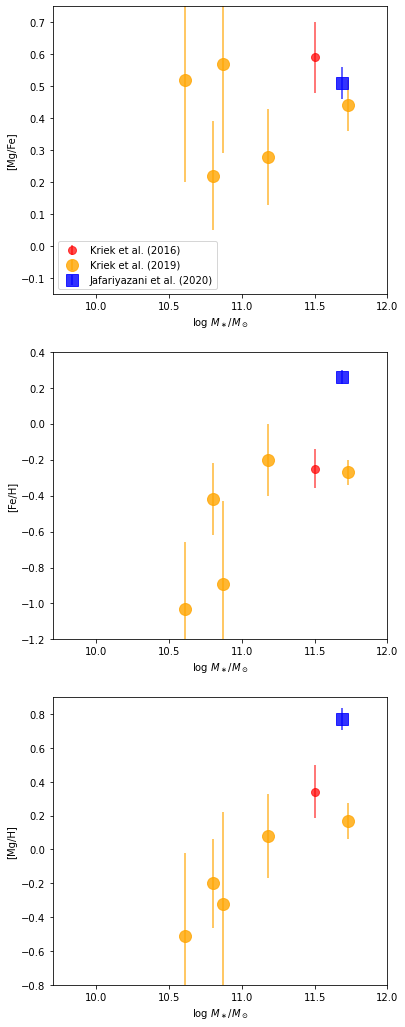

In [12]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[9.7, 12])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[9.7, 12])


# [Mg/H]
##########

for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[9.7, 12])


[Text(0.5, 0, 'log $M_\\ast/M_\\odot$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.9),
 (10.5, 12.0)]

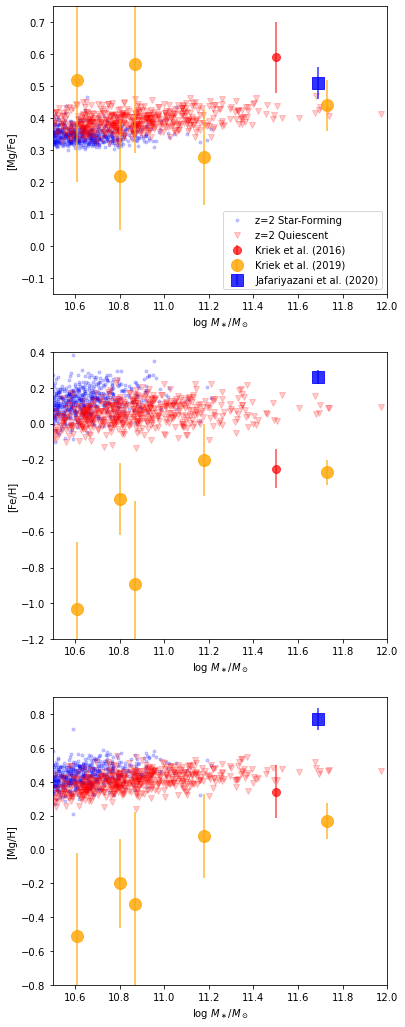

In [27]:

# plot of abundances vs stellar mass

fig, axs = plt.subplots(3, 1, figsize=(6,18))
markersize = 6


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(total_mass[starforming_selection], MgFe_1kpc[starforming_selection], 'b.',
           alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(total_mass[quiescent_selection], MgFe_1kpc[quiescent_selection], 'rv',
           alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[10.5, 12])
axs[0].legend(loc='lower right')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(total_mass[starforming_selection], FeH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(total_mass[quiescent_selection], FeH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(total_mass[starforming_selection], MgH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(total_mass[quiescent_selection], MgH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[10.5, 12])


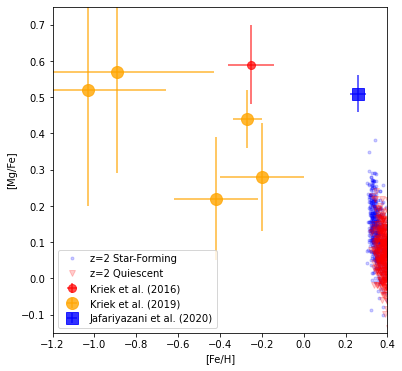

In [26]:

# [Mg/Fe] vs [Fe/H]
####################


fig, ax = plt.subplots(figsize=(6,6))

# z=2 galaxies
ax.plot(MgFe_1kpc[starforming_selection], FeH_1kpc[starforming_selection], 'b.',
           alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
ax.plot(MgFe_1kpc[quiescent_selection], FeH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    ax.errorbar(s['[Fe/H]'], s['[Mg/Fe]'], xerr=s['[Fe/H]_err'], yerr=s['[Mg/Fe]_err'], **s.meta)

ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[-1.2, 0.4])
ax.legend(loc='lower left')




[Text(0.5, 0, 'log $R_e / kpc$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.8),
 (-0.5, 1.0)]

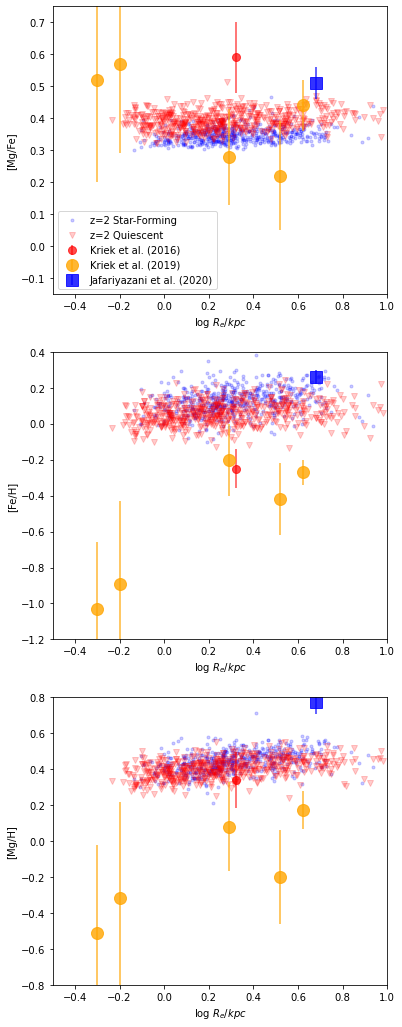

In [38]:

# plot of abundances vs effective size

fig, axs = plt.subplots(3, 1, figsize=(6,18))


# [Mg/Fe]
##########

# z=2 galaxies
axs[0].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_1kpc[starforming_selection], 'b.', 
            alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[-0.5, 1.0])
axs[0].legend(loc='lower left')



# [Fe/H]
##########

# z=2 galaxies
axs[1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1].errorbar(np.log10(s['Re']), s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[-0.5, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2].plot(np.log10(halfmass_radius[starforming_selection]), MgH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[2].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2].errorbar(np.log10(s['Re']), s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.8], xlim=[-0.5, 1.0])


[Text(0.5, 0, 'log $R_e / kpc$'),
 Text(0, 0.5, '[Mg/H]'),
 (-0.8, 0.8),
 (-0.5, 1.0)]

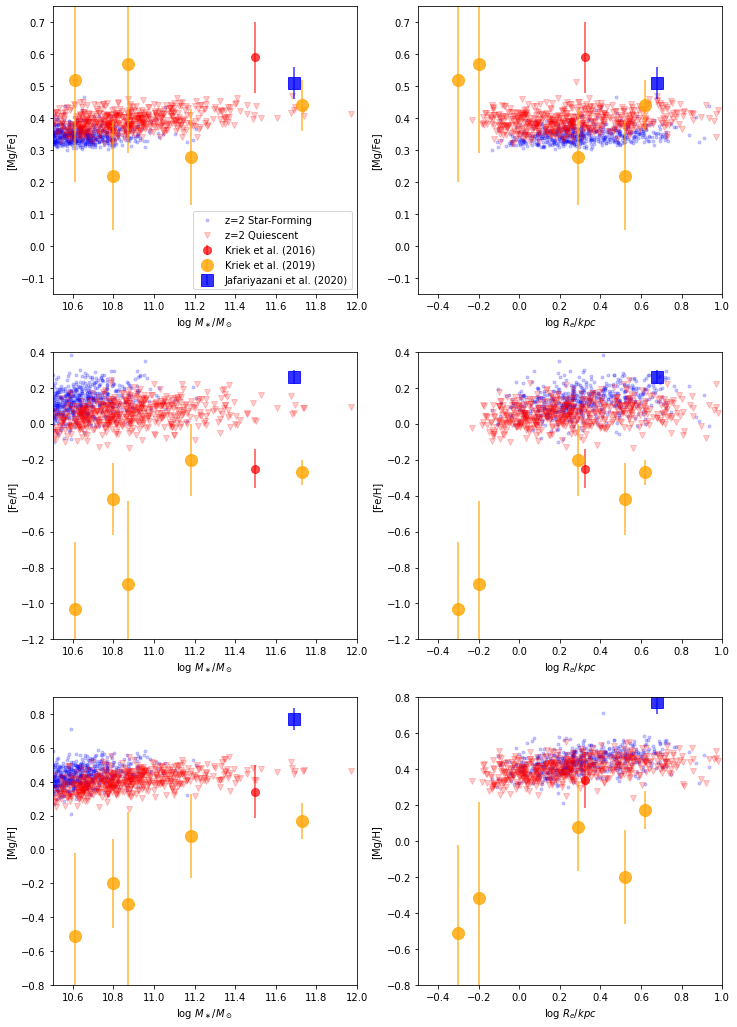

In [40]:

# plot of abundances vs stellar mass and effective size

fig, axs = plt.subplots(3, 2, figsize=(12,18))
markersize = 6

##### STELLAR MASS #######################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][0].plot(total_mass[starforming_selection], MgFe_1kpc[starforming_selection], 'b.',
           alpha=0.2, label='z=2 Star-Forming', markersize=markersize, zorder=0)
axs[0][0].plot(total_mass[quiescent_selection], MgFe_1kpc[quiescent_selection], 'rv',
           alpha=0.2, label='z=2 Quiescent', markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0][0].errorbar(s['logMstar'], s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[10.5, 12])
axs[0][0].legend(loc='lower right')



# [Fe/H]
##########

# z=2 galaxies
axs[1][0].plot(total_mass[starforming_selection], FeH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[1][0].plot(total_mass[quiescent_selection], FeH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1][0].errorbar(s['logMstar'], s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[10.5, 12])


# [Mg/H]
##########

# z=2 galaxies
axs[2][0].plot(total_mass[starforming_selection], MgH_1kpc[starforming_selection], 'b.',
           alpha=0.2, markersize=markersize, zorder=0)
axs[2][0].plot(total_mass[quiescent_selection], MgH_1kpc[quiescent_selection], 'rv',
           alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2][0].errorbar(s['logMstar'], s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][0].set(xlabel=r'log $M_\ast/M_\odot$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.9], xlim=[10.5, 12])


##### EFFECTIVE SIZE ########################################################################

# [Mg/Fe]
##########

# z=2 galaxies
axs[0][1].plot(np.log10(halfmass_radius[starforming_selection]), MgFe_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[0][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgFe_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[0][1].errorbar(np.log10(s['Re']), s['[Mg/Fe]'], yerr=s['[Mg/Fe]_err'], **s.meta)

axs[0][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/Fe]',
      ylim=[-0.15, 0.75], xlim=[-0.5, 1.0])
# axs[0][1].legend(loc='lower left')



# [Fe/H]
##########

# z=2 galaxies
axs[1][1].plot(np.log10(halfmass_radius[starforming_selection]), FeH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[1][1].plot(np.log10(halfmass_radius[quiescent_selection]), FeH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[1][1].errorbar(np.log10(s['Re']), s['[Fe/H]'], yerr=s['[Fe/H]_err'], **s.meta)

axs[1][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Fe/H]',
      ylim=[-1.2, 0.4], xlim=[-0.5, 1.0])


# [Mg/H]
##########

# z=2 galaxies
axs[2][1].plot(np.log10(halfmass_radius[starforming_selection]), MgH_1kpc[starforming_selection], 'b.', 
            alpha=0.2, markersize=markersize, zorder=0)
axs[2][1].plot(np.log10(halfmass_radius[quiescent_selection]), MgH_1kpc[quiescent_selection], 'rv', 
            alpha=0.2, markersize=markersize, zorder=0)

# observations
for s in samples:
    axs[2][1].errorbar(np.log10(s['Re']), s['[Mg/H]'], yerr=s['[Mg/H]_err'], **s.meta)

axs[2][1].set(xlabel=r'log $R_e / kpc$', ylabel='[Mg/H]',
      ylim=[-0.8, 0.8], xlim=[-0.5, 1.0])